In [54]:
import imageio

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [55]:
import cv2

In [56]:
img_rgb = imageio.imread('toad_and_jiang.jpg')

In [57]:
img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

In [58]:
toad = img[:,:140]

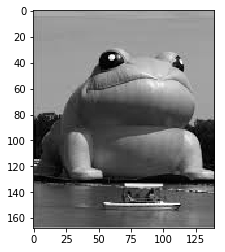

In [59]:
plt.imshow(toad, cmap='gray')

In [60]:
toad_noised = np.clip(toad + 25*np.random.randn(*toad.shape), 0,255)

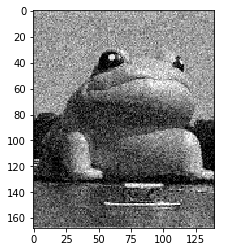

In [61]:
plt.imshow(toad_noised, cmap='gray')

In [62]:
import scipy

In [63]:
import scipy.ndimage

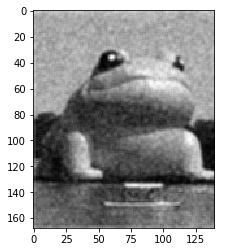

In [64]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((3,3),1/9)), cmap='gray')

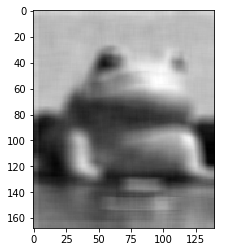

In [65]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((10,10),1/100)), cmap='gray')

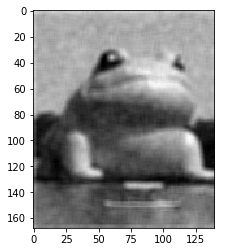

In [66]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((5,5),1/25)), cmap='gray')

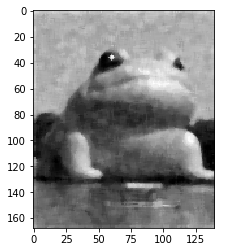

In [67]:
plt.imshow(scipy.ndimage.median_filter(toad_noised, 5), cmap='gray')

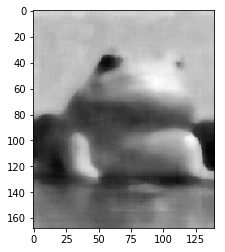

In [68]:
plt.imshow(scipy.ndimage.median_filter(toad_noised, 10), cmap='gray')

In [69]:
toad_noised = np.clip(toad + 15*np.random.randn(*toad.shape), 0,255)

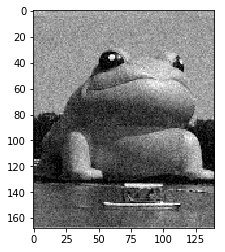

In [70]:
plt.imshow(toad_noised, cmap='gray')

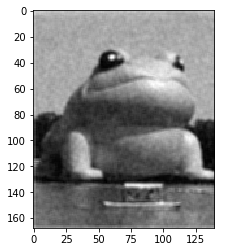

In [71]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((3,3),1/9)), cmap='gray')

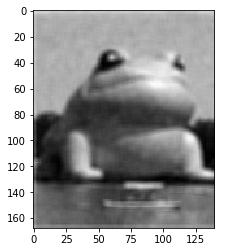

In [72]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((5,5),1/9)), cmap='gray')

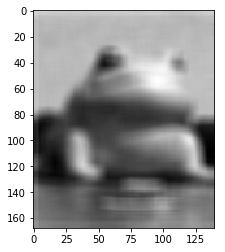

In [73]:
plt.imshow(scipy.ndimage.convolve(toad_noised, np.full((10,10),1/9)), cmap='gray')

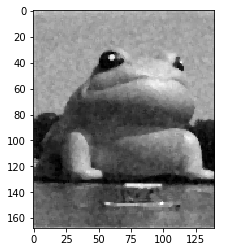

In [74]:
plt.imshow(scipy.ndimage.median_filter(toad_noised, 3), cmap='gray')

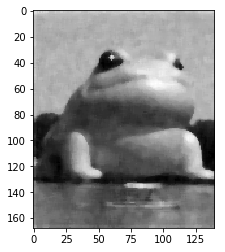

In [75]:
plt.imshow(scipy.ndimage.median_filter(toad_noised, 5), cmap='gray')

In [76]:
toad.shape

(168, 140)

In [77]:
np.prod(toad.shape)

23520

In [123]:
jj,ii = np.meshgrid(np.arange(toad.shape[1]), np.arange(toad.shape[0]))

In [124]:
ii.shape

(168, 140)

In [125]:
jj.shape

(168, 140)

In [126]:
ii

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [165, 165, 165, ..., 165, 165, 165],
       [166, 166, 166, ..., 166, 166, 166],
       [167, 167, 167, ..., 167, 167, 167]])

In [127]:
jj

array([[  0,   1,   2, ..., 137, 138, 139],
       [  0,   1,   2, ..., 137, 138, 139],
       [  0,   1,   2, ..., 137, 138, 139],
       ...,
       [  0,   1,   2, ..., 137, 138, 139],
       [  0,   1,   2, ..., 137, 138, 139],
       [  0,   1,   2, ..., 137, 138, 139]])

In [129]:
iijj = np.stack([ii,jj],2)
iijj.shape

(168, 140, 2)

In [130]:
IJ = iijj.reshape(-1,2).astype(float)
IJ.shape

(23520, 2)

In [131]:
IJ[:5,:],IJ[1995:2000,:]

(array([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.]]), array([[14., 35.],
        [14., 36.],
        [14., 37.],
        [14., 38.],
        [14., 39.]]))

局部线性回归好像没提供什么特殊计算方式，直接用它的不考虑交叉检验都要计算23520次来得到所有结果可还行。但试图batch处理的话，
那个$W_x$的等价物相当于一个$23520 \times 23520$矩阵，这个没法存。当然可以考虑每个batch 100个什么的那样算。。简直吃饱了没事。
先看看不用batch的算出来多慢再说，不过这么折腾cross validation肯定是没法做了。

In [132]:
ij = np.array([50, 100]).astype(float)

In [133]:
import scipy.stats as stats

In [134]:
dis = stats.norm()
K = lambda x:dis.pdf(x) # h=1

In [135]:
Wx = K(np.abs(ij - IJ).sum(axis=1))

In [136]:
_X = (ij - IJ).sum(axis=1)

In [137]:
X = np.c_[np.ones_like(_X), _X]

In [138]:
X.shape

(23520, 2)

In [139]:
Y = toad.reshape(-1,1)

In [140]:
a = np.linalg.inv((X.T * Wx) @ X) @ (X.T * Wx) @ Y

In [141]:
a

array([[205.56007178],
       [  2.95871036]])

In [142]:
from itertools import product

In [143]:
list(product(range(3),range(3)))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [144]:
ij

array([ 50., 100.])

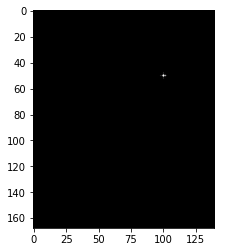

In [145]:
plt.imshow(Wx.reshape(toad.shape), cmap='gray')

In [146]:
%%time

mat = np.empty(toad.shape+(2,))
for _ij in product(range(toad.shape[0]), range(toad.shape[1])):
    ij = np.array(_ij).astype(float)
    Wx = K(np.abs(ij - IJ).sum(axis=1))
    _X = (ij - IJ).sum(axis=1)
    X = np.c_[np.ones_like(_X), _X]
    
    a = np.linalg.inv((X.T * Wx) @ X) @ (X.T * Wx) @ Y
    
    mat[_ij[0], _ij[1], :] = a.squeeze()

Wall time: 2min 22s


In [147]:
mat.shape

(168, 140, 2)

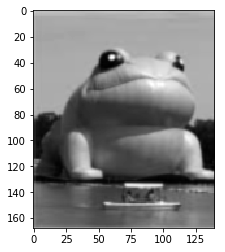

In [148]:
plt.imshow(mat[:,:,0], cmap='gray')

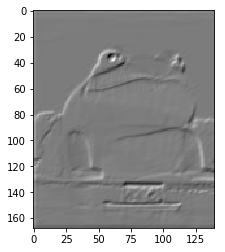

In [149]:
plt.imshow(mat[:,:,1], cmap='gray')

In [48]:
%%time

mat = np.empty(toad.shape+(2,))
for _xy in product(range(toad.shape[1]), range(toad.shape[0])):
    xy = np.array(_xy).astype(float)
    Wx = K(np.abs(xy - IJ).sum(axis=1))
    _X = (xy - IJ).sum(axis=1)
    X = np.c_[np.ones_like(_X), _X]
    
    a = np.linalg.inv((X.T * Wx) @ X) @ (X.T * Wx) @ Y
    
    mat[_xy[1], _xy[0], :] = a.squeeze()

Wall time: 2min 50s


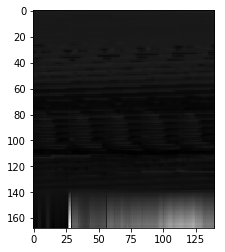

In [49]:
plt.imshow(mat[:,:,0], cmap='gray')

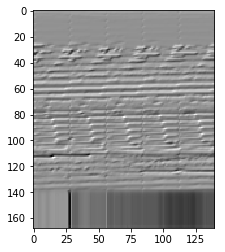

In [50]:
plt.imshow(mat[:,:,1], cmap='gray')

In [51]:
%%time

mat = np.empty(tuple(np.array(toad.shape)//3)+(2,))
for _xy in product(range(toad.shape[1]//3), range(toad.shape[0]//3)):
    xy = np.array(_xy).astype(float)
    Wx = K(np.abs(xy - IJ).sum(axis=1))
    _X = (xy - IJ).sum(axis=1)
    X = np.c_[np.ones_like(_X), _X]
    
    a = np.linalg.inv((X.T * Wx) @ X) @ (X.T * Wx) @ Y
    
    mat[_xy[1], _xy[0], :] = a.squeeze()

Wall time: 17.9 s


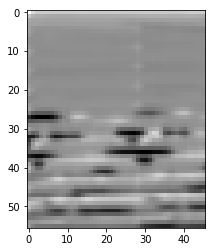

In [52]:
plt.imshow(mat[:,:,0], cmap='gray')

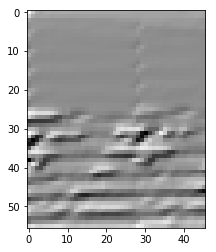

In [53]:
plt.imshow(mat[:,:,1], cmap='gray')